In [8]:
from IPython.display import Markdown, display

display(Markdown("README.md"))

# Basics of Mobile Robotics - Project
Project for the EPFL course Basics of Mobile Robotics. 

2023, fall semester

# Group members
Badil Mujovi (274632) - Currently in Robotics, previously did a Bachelor at HEIG-VD in Microengineering \
Aubin Mercier (316260)\
Mehmet Furkan Dogan (370234)\
Andrea Grillo (371099)

# Demonstration
<center><div><img src = "images\demonstration.gif" width = 350></div></center>

## Introduction
This project aims to combine vision, global and local navigation, and filtering to maneuver a Thymio robot in a predetermined environment.

Our environment consist of a white floor delimited by ArUco markers in the 4 corners. There is an ArUco marker on the Thymio and the goal is an ArUco marker too. Static obstacles are black polygons printed on the map. A camera is placed on top of the environment, to build a map of the static obstacles and compute the optimal path towards the goal.

The Thymio is placed at a random position, the camera tracks its position and orientation, and it has to reach the goal following the optimal path. The system is robust to 3D dynamic obstacles placed along the path, as well as camera covering for short periods of time and kidnapping, that is moving the robot to another place during its activity.

Our implementation includes the following features:
- Computer Vision for detecting obstacles and building the map
- Computer Vision for the tracking of the pose of the Thymio
- Global navigation computes the optimal path from the map using a visibility graph
- Local navigation makes the Thymio follow the computed path as a list of waypoints
- Obstacle avoidance by sensing the environment with proximity sensors
- Extended Kalman Filter allows pose estimation when the camera is covered using the fusion of data from camera and odometry
- Resilience to kidnapping by recomputing the global path when the camera detects that the position of the Thymio has changed


The main code of the system is implemented in this Jupyter noteboook. The submodules of the system have been implemented in Python classes, each one in a separate file. They are the following:
- Computer Vision - vision_thymio.py
- Global Navigation - global_navigation.py
- Extended Kalman Filter - extended_kalman_filter.py
- Local Navigation - local_navigation.py


Some scripts for testing the subsystems have been written, and they are located under the 'test' directory.
Moreover, for the estimation for the variance matrices for the Kalman Filter, measurements and subsequent data analysis in Matlab have been conducted. All the files related to this part can be found in the 'Sensor Noise Measurement' directory.

Below there is an explanation of each submodule, followed by the explanation of the main loop of the code.

## 1. Computer Vision
The computer vision used for this project is composed of many parts, such as the correction of distortion of the camera, the perspective correction of the camera feed, the detection of obstacles and the detection of Aruco markers whose use will be explained later. The obstacle detection will be explained in the [Global navigation](#section_id) section because it was implemented for the global navigation. This part has been almost entirely done using the OpenCV library.

### Distortion correction and camera calibration
Before doing any image processing, the camera had to be calibrated to take into account the possible distortion stemming from the optical components of the camera. This calibration has been done following this [OpenCV guide](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

Two set of values are needed to get an undistorted and corrected picture from the camera : the first being the camera matrix and the second the distortion matrix. These two matrices can be obtained by taking pictures of a ChAruco board at different angles and are of the following form :
$$
M = 
\left( \begin{matrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{matrix} \right)
$$
where $f_x$ and $f_y$ are the focal lengths and $c_x$ and $c_y$ are the optical centers in x and y axis. We also get the distortion coefficients : 
$$
D = 
\left( \begin{matrix} 
k_1 & k_2 & p_1 & p_2 & k_3
\end{matrix}\right)
$$
where the $k_i$ values are the spherical aberration coefficients and the $p_i$ ones are the tangential aberration coeeficients. The exact meaning of these coefficients can be found in the OpenCV guide. In the code, we can use the method <code>cv2.calibrateCamera()</code>. This method takes images of a ChAruco board and extrapolates the matrices. We can then use the <code>cv2.getOptimalNewCameraMatrix()</code> and <code>cv2.undistort()</code> functions to get the undistorded image. The following method in the <code>Vision_Thymio</code> class give us a corrected frame :
```py
def getFrame(self):
    # camera and distortion matrices
    mtx = np.array([[989.7401734,  0.,           653.72226958],
                    [0.,           998.64802591, 347.61109886],
                    [0.,           0.,           1.          ]])
    dist = np.array([[ 0.12258701, -0.76974406, -0.00790144,  0.00456124,  1.16348775]])
    
    _, frame = self.cap.read()
    
    # undistorted frame
    h,  w = frame.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv2.undistort(frame, mtx, dist, None, newcameramtx)
    
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst
```

### Aruco markers detection
OpenCV has a module to detect Aruco markers which, in our case, are used to detect the border of our working space as well as the positions and orientations of the Thymio and the goal. This detection is done with the <code>cv2.detectMarkers()</code> method. What OpenCV does is that it applies an adaptive thresholding and finds the contours that could be square shapes. Then it does a perspective transformation on each square shapes to check if there is a binary code corresponding to an ID from the aruco dictionnary used. The method simply returns the IDs found and the corners of each marker. The <code>initDictAruco()</code> and <code>detectArucoMarkers()</code> methods in the <code>Vision_Thymio</code> class give us the markers IDs and corners.

In our case, the markers with IDs 1 and 2 corresponds respectively to the thymio and the goal. The markers with IDs from 3 to 6 give us the corners of our working ROI. The positions of the goal and the Thymio are given by finding the mean value of their corresponding marker's corners. As for the orientation of the Thymio, it is found by taking the vector given by two corners (which are always returned in a specific order). The methods to find these values are <code>getGoalPosition</code> and <code>getGoalPosition</code>. We decided to use this method simply because it is reliable and already implemented in OpenCV

### Perspective transformation
For our work, we need to find the position of the thymio, the goal and the obstacles with respect to our ROI. To do that, we find the Arcuo markers of our ROI and get the position of their inner corners. Then, by using the <code>cv2.getPerspectiveTransform()</code> method, we can map this ROI into a new image with corrected perspective and get a transformation matrix. In our case, we measured the size of our ROI in centimeters, which let us get an image with the same aspect ratio. The <code>getPerspectiveAndScaling()</code> method in the <code>Vision_Thymio</code> class gives us the desired result.

This method also gives us a scaling value in $cm/px$ to compute the real distances of each points. We then used the <code>getCorrectedImage()</code> method from the <code>Vision_Thymio</code> class to get the transformed image. An example code can't be given for this part as it would depend heavily on the detection of the aruco markers as we intended. Here's the stage we used (the pdf file can be found in the images folder) :
<center><div><img  src = "images\stage_used.png" width = 500></div></center>

## 2. Path Planning
<a id='section_id'></a>
This part of the project is focused on the global navigation and optimal path finding and, if not mentionned otherwise, the functions used can be found in the global_navigation.py file. The path finding is done in three parts : the vision needed to find the static obstacles, the creation of the visibility graph and the computing of the optimal path. We use the following image as an example instead of a camera feed to showcase the steps for the global navigation :
<center><div><img src = "images\shapes.png" width = 500></div></center>

### Vision for the obstacles
The vision needed to find the obstacles has been included in the global navigation module instead of the vision module to simplify the creation of the functions for the optimal path finding. We decided to use black convex polygons as obstacles to simplify their detection. The first step to get the obstacles is to apply some image processing. First, we apply blurring filters (Gaussian and median) to remove noise and small features. Then we apply an adaptive thresholding which lets us apply morphological operations to the image. Those operations are done with <code>cv2.morphologyEx()</code> and <code>cv2.dilate()</code> methods of OpenCV. In our case, we use a morphological gradient, which basically gives the difference between the eroded and dilated image to find edges. All this processing is done by the following function :
```py
def prepareImage(frame, threshold = 100):
    kernel = np.ones((2,2),np.uint8)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   
    
    # Noise reduction 
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = cv2.medianBlur(gray, 3)

    _ ,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    thresh = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
    thresh = cv2.dilate(thresh, kernel, iterations = 5)
        
    return thresh
```
After the processing, we get the following result :
<center><div><img src = "images\Processed_Image.png" width = 500></div></center>

We can then find the contours of our shapes and reduce them to only the main vertices of the polygons. This is the main reason why simple shapes have been chosen as obstacles, but the code should still work with more complex shapes. The contours are found using the <code>cv2.findContours()</code> method.

The <code>drawSimplifiedContours()</code> function returns the list of all the simplified contours, from function <code>approx_contour()</code>, scaled by a value corresponding to a bit more than the length of the Thymio in pixels from function <code>scalePoints()</code>. The scaling is done by using as a direction the vector given by the sum of the pair of vectors created by using the main vertex and the two adjacent vertices. This vector is normalized and scaled by the length of the Thymio. This method of scaling does not work with concave shapes, as they would be scaled inward. Here is the resulting image :
<center><div><img src = "images\Scaled_contours.png" width = 500></div></center>

With, in green, the normal contour and, in red, the scaled one. It is possible to see that the bottom vertex of the hexagon is not correct, this is due to the fact that the contour is not detected at the exact position of the vertex after the dilation of the shape. Still, the result is good enough. It is also important to note that some points can end up outside the ROI after the scaling. In our case, the Thymio could still follow the path with the help of the Kalmann filter, but we decided to remove them to make the code more robust. This was done by making those points a big value such that they are not considered for the optimal path planning.

### Visibility graph
For this part, we decided to use a module called PyVisGraph, which can compute the visibility graph if we give the obstacles as a set of points. This module is used because the creation of the visibility graph is optimized and simple to implement, and it can also find the shortest path. 

As explained before, we get the simplified and scaled contours of the obstacles in a list using the <code>getVisibilityGraph()</code> method from the <code>Vision_Thymio</code> class, to which we add the start and goal position with the <code>addStartAndGoal()</code>. We then use the <code>VisGraph</code> class and <code>build()</code> method to compute the graph. This method takes a list of points array defining the shape of all the obstacles. The way this module creates the graph is by checking if there's an obstacle between any pair of points, and if not they are connected.

### Optimal path
The PyVisGraph module has a <code>shortest_path()</code> method in the <code>VisGraph</code> class. This method uses the Dijkstra algorithm to compute the optimal path with a given start and goal position. Here is the result obtained with the example image :
<center><div><img src = "images\Optimal_path.png" width = 500></div></center>

The code used to do the simulation can be found inside the `test` directory, in the `global_navigation_test.py` file.

## 3. Filtering
### Extended Kalman Filter Model
We are using the following model for extended Kalman filter implementation:
$$
x_{i+1} = f(x_i,u_i) + w\\
z_{i+1} = h(x_i) + v
$$

where:

$$
x = 
\begin{bmatrix}
x\\
y\\
\theta\\
\bar{v}\\
\omega
\end{bmatrix}
$$

$$
u = 
\begin{bmatrix}
\bar{v}_{\textrm{sensor}}\\
\omega_{\textrm{sensor}}
\end{bmatrix}
$$

State transition model:
$$
f(x_i,u_i) = 
\begin{bmatrix}
x_{i+1}\\
y_{i+1}\\
\theta_{i+1}\\
\bar{v}_{i+1}\\
\omega_{i+1}
\end{bmatrix} = 
\begin{bmatrix}
x_i + \bar{v}_i \cdot \Delta t \cdot \cos(\theta_i)\\
y_i + \bar{v}_i \cdot \Delta t \cdot \cos(\theta_i)\\
\theta_i + \omega_i \cdot \Delta t\\
\bar{v}_{\textrm{sensor}}\\
\omega_{\textrm{sensor}}
\end{bmatrix}
$$

State transition matrix can be found by calculating the Jacobian of the nonlinear state transition model.

$$
F = 
\begin{bmatrix}
1 & 0 & -\bar{v}\cdot \Delta t \cdot \sin(\theta_i) & 0 & 0\\
0 & 1 & -\bar{v}\cdot \Delta t \cdot \cos(\theta_i) & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

State transition can be implemented as:
```py
    def _state_transition(self, x, u, dt):
        # State transition function for a differential drive robot
        v_bar,omega = u

        x_new = x[0] + v_bar * dt * np.cos(x[2])
        y_new = x[1] + v_bar * dt * np.sin(x[2])
        theta_new = x[2] + omega * dt

        return np.array([x_new, y_new, theta_new, v_bar, omega])

    def _calculate_state_transition_matrix(self, x, u, dt):
        # Jacobian matrix A of the state transition function

        v_bar,omega = u
        #v_right, v_left = u
        #v_bar = (v_right + v_left) / 2.0
        theta_i = x[2]

        A = np.array([
            [1, 0, -v_bar * dt * np.sin(theta_i), 0, 0],
            [0, 1, v_bar * dt * np.cos(theta_i), 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ])

        return A
```

Measurement model:
$$
h(x_i) = 
\begin{bmatrix}
x_{\textrm{camera}}\\
y_{\textrm{camera}}\\
\theta_{\textrm{camera}}\\
\bar{v}_{\textrm{sensor}}\\
\omega_{\textrm{sensor}}
\end{bmatrix}
$$

Measurement jacobian:
$$
H = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

Measurement model can be implemented as:
```py
    def _measurement_model(self, x):
        # x, y, and theta are measured usıng the camera
        # v_right and v_left are measured using velocity sensors
        return x

    def _calculate_measurement_jacobian(self, x):
        # Calculate the Jacobian matrix H of the measurement model
        H = np.eye(5)

        return H
```

### Prediction Step
$$
x_{i+1} = f(x_i,u_i)
$$
$$
P = F \cdot P \cdot F^T + Q
$$
where $P$ is the error covariance matrix and Q is the process noise covariance matrix. We can implement that in pyhon as:

```py
    def predict(self, control_input, dt):
        # Update the state transition matrix A based on the control input
        A = self._calculate_state_transition_matrix(self.state, control_input, dt)

        # Predict the state and error covariance
        self.state = self._state_transition(self.state, control_input, dt)
        self.P = A @ self.P @ A.T + self.process_noise_cov

        self._angle_modulus()
```

### Update Step
Innovation covariance matrix can be calculated as:
$$
S = H \cdot P \cdot H^T + R
$$
Optimal Kalman gain can be calculated as:
$$
K = P \cdot H^T \cdot S^{-1}
$$
Updated state estimate:
$$
x_{i+1} = x_i + K \cdot (z_i - H_i \cdot x_i)
$$
Updated error covariance:
$$
P = (I - K\cdot H)\cdot P
$$

We can implement that in pyhon as:
```py
    def update(self, measurement):
        # Calculate the measurement Jacobian matrix H
        H = self._calculate_measurement_jacobian(self.state)

        # Calculate the innovation covariance S
        S = H @ self.P @ H.T + self.measurement_noise_cov

        # Calculate the Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)

        # Update the state and error covariance
        innovation = measurement - self._measurement_model(self.state)
        self.state = self.state + K @ innovation
        self.P = (np.eye(self.state_dim) - K @ H) @ self.P

        self._angle_modulus()
```

### Tuning Covariance Matrices

To tune the measurement covariance matrix, we used the measured speed values when motor is commanded to run at a fixed speeds. You can see the distributions of the wheel speed measurements for different speeds.

<center><div><img src = "images\wheel_speed_distribution.png" width = 350></div></center>

To find the wheel speed sensor noise covariance matrix, the following error distribution is used.

<center><div><img src = "images\measurement_error_distribution.png" width = 350></div></center>

We have found the camera noise covariance matrix in a similar way. Lastly, process noise covariance matrix is tuned by trial and error to get an optimal behaviour.

## 4. Local Navigation
The goal of the Local Navigation submodule is to make the Thymio follow the path computed by the Global Navigation part, while making the Thymio avoid dynamic obstacles that can be placed along the path.

The path is given as a list of tuples (x,y) representing the waypoints of the path. The path is initialized using the `define_path` function. In this function, also the `waypoint_counter` variable is initialized. This variable keeps track of which waypoint we are aiming for at the moment.

#### Control routine
The function which is called at every loop iteration is `control`, whose role is to decide whether to apply the controller to follow the path or the local avoidance routine.
The system starts in the <i>path_follow</i> modality, which is changed to <i>obstacle_avoidance</i> whenever the proximity sensor detect an obstacle. When no obstacle is detected anymore, the obstacle avoidance routine will be run for the following 5 loop cycles before going back to the <i>path_follow</i> mode, to ensure that the obstacle is really been overcome and that the Thymio is far enough from it.


#### Obstacle avoidance routine
The obstacle avoidance routine, as implemented in the `obst_avoid` function, is a simple application of a Neural Network as seen during the course.
<center><div><img src = "images\NNobstacleAvoidance.png" width = 350></div></center>

The input of the network are the readings of the sensors, which are then multiplied by the weights and summed together to get the velocity of the motors.
The two rear sensors of the Thymio have been assigned zero weight, as the Thymio will always move forward so it cannot detect any obstacle from the rear.
To make the Thymio go forward during the obstacle avoidance phase, a constant velocity is added to both neurons as an additional fixed input.

The main difference with the code used during the exercise session, is that in that case the routine has been run on the Thymio using the Aseba transpiler. To integrate the obstacle avoidance in the whole project, the routine is run in Python on the computer. For this reason, the communication latency has to be taken into account, and this leads to the necessity to tune the sampling time in an effective way, as will be explained after.

The weights of the two neurons have been tuned empirically by trial and error. One interesting detail to note is that for the central sensor two different weights have been chosen for the left and right wheel. This is because otherwise the Thymio could get blocked in case of an obstacle exactly in front of the robot and perpendicular to the longitudinal line of the Thymio. By setting asymmetrical weights, the Thymio will rotate and not get blocked in this situation.



#### Path follow routine
The function `path_follow` has the pose of the Thymio as the only parameter, as the path is defined as an attribute of the Local Navigation class.
The idea is that the two variables to control are the linear and angular velocities, respectively $ v $ and $ \omega $.

The controller chosen is a simple proportional controller for the $ \omega $, and a predefined fixed velocity for $ v $. 

The control law is therefore:
$$ v = v_{fixed} $$
$$ \omega = K_p ( \theta - \gamma) $$
where $ \theta $ is the orientation of the Thymio and $ \gamma $ is the angle of the vector connecting the Thymio to the waypoint. 

### TODO INSERT IMAGE of the angles

The routine checks if the waypoint has been reached, by checking that the actual pose is within a distance $ \epsilon $ of the waypoint. If the condition is true, the `waypoint_counter` variable is incremented and the function is called recursively, until the last goal is reached.

The gain value $ K_p $, the fixed velocity $ v_{fixed} $, and the $ \epsilon $ parameter have been tuned empiricaly by trial and error to obtain the best performance possible of the system as a whole.

### Simulating the controller
To make sure that the controller works before testing it with the Thymio, a simulation has been done as a proof of concept.
The simulation can be done defining a random path and start point, and using the formulas below to integrate the position of the Thymio at every step:
$$ x_{i+1} = x_i + v \cdot cos(\theta) \cdot \Delta t $$
$$ y_{i+1} = y_i + v \cdot sin(\theta) \cdot \Delta t $$
$$ \theta_{i+1} + \theta_i + \omega \cdot \Delta t $$
The result of the simulation can be seen in the graph below:
<center><div><img src = "images\controller.png" width = 500></div></center>

The code used to do the simulation can be found inside the `test` directory, in the `local_navigation_test.py` file.




## Complete code

TODO


choice of DT

## Conclusion

# SCAFFOLDING

### Installing dependencies

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyvisgraph
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install opencv-contrib-python
!{sys.executable} -m pip install tqdm

^C


### Constant Definition, libraries and submodules import

In [1]:
#  - - - CONSTANT DEFINITION - - -

USE_THYMIO = True

# sampling time
DT = .15

# 
EPSILON_KIDNAP = 20

HEIGHT_ROI = 72
WIDTH_ROI  = 107.4 

print("Constants defined")

#  - - - IMPORTS - - - 
import tdmclient.notebook
import time
import numpy as np
import cv2
from matplotlib import pyplot as plt

import local_navigation
import extended_kalman_filter
import vision_thymio
import global_navigation as gn

print("Import executed successfully")

if USE_THYMIO:
    await tdmclient.notebook.start()
    print("Successfully connected to Thymio.")

Constants defined
Import executed successfully
Successfully connected to Thymio.


### Classes instantiation, helper functions to interact with the Thymio

In [2]:
# ISTANTIATE OBJECTS OF CLASSES

vis = vision_thymio.Vision_Thymio(1)
local_nav = local_navigation.Local_Navigation()
ekf = extended_kalman_filter.ExtendedKalmanFilter()

print("Classes defined correctly.")


# FUNCTION FOR THYMIO INTERACTION DEFINITION

@tdmclient.notebook.sync_var
def motor_go(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

@tdmclient.notebook.sync_var
def odometry():
    global motor_left_speed, motor_right_speed
    return (motor_left_speed, motor_right_speed)

print("Thymio functions defined correctly.")

Init Vision Thymio
Init Local Navigation
Init Extended Kalman Filter
Classes defined correctly.
Thymio functions defined correctly.


In [3]:
# TEST THAT THE THYMIO IS LISTENING TO US
motor_go(200,200)
time.sleep(1)
motor_stop()

### Perspective and scaling of the image, static obstacle detection

In [4]:
# init of the perspective and scaling of the image
vis.getPerspectiveAndScaling(width_roi=WIDTH_ROI, height_roi=HEIGHT_ROI)

# get obstacles on the map
img,_ = vis.getCorrectedImage()
staticObstacleList, frame = vis.getVisibilityGraph(img)

staticObstacleList = staticObstacleList.copy()

print(staticObstacleList)


testing point  926 447
testing point  926 447
testing point  573 482
testing point  573 482
testing point  631 877
big >x
testing point  631 100000
testing point  954 839
big >x
testing point  954 100000
testing point  112 266
testing point  112 266
testing point  36 791
testing point  36 791
testing point  458 767
testing point  458 767
testing point  189 684
testing point  189 684
testing point  164 -6
big <x
testing point  164 -100000
testing point  551 479
testing point  551 479
testing point  590 -42
big <x
testing point  590 -100000
testing point  1104 -45
big <x
testing point  1104 -100000
testing point  683 -25
big <x
testing point  683 -100000
testing point  709 322
testing point  709 322
testing point  1100 304
testing point  1100 304
[array([[   926,    447],
       [   573,    482],
       [   631, 100000],
       [   954, 100000]], dtype=int32), array([[112, 266],
       [ 36, 791],
       [458, 767],
       [189, 684]], dtype=int32), array([[    164, -100000],
       [   

### Detection of the Thymio and the goal, optimal path computation

Found thymio and goal at iteration 4
Position of the thymio:  [102.78  10.08] 1.5330783743280325
Position of the goal:  [14.4 13.5]
Computed optimal path:  [(102.78, 10.08), (99.0, 27.36), (49.589999999999996, 43.11), (14.399999999999999, 13.5)]


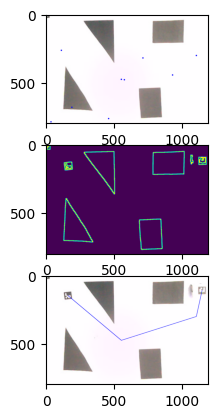

Unchecked Raise(exc=Call(func=Name(id='Exception', ctx=Load()), args=[Constant(value='ERROR - cannot find thymio or goal thymio: '), Name(id='foundThymio', ctx=Load()), Constant(value=', goal: '), Name(id='foundGoal', ctx=Load())], keywords=[]))


In [9]:
def detectAndComputePath():
    global path,staticObstacleList,ekf,local_nav,path_img, oldThymioPos, measurement

    try:
        foundGoal = foundThymio = False
        goalPos = []
        thymioPos = []

        # try ten times to get thymio and goal position on the map, if not print error and exit
        for i in range(10):
            img,_ = vis.getCorrectedImage()
            ids,corners = vis.detectArucoMarkers(img)

            if not foundGoal:
                foundGoal, goalPos = vis.getGoalPosition(ids, corners)
            if not foundThymio:
                foundThymio, thymioPos = vis.getThymioPos(ids,corners) 

            if foundGoal and foundThymio:
                break
            
            time.sleep(0.1)
        if not (foundGoal and foundThymio):
            raise Exception("ERROR - cannot find thymio or goal thymio: ", foundThymio, ", goal: ", foundGoal)

        print(f"Found thymio and goal at iteration {i}")
        print(f"Position of the thymio: ", thymioPos[0], thymioPos[1])
        print(f"Position of the goal: ", goalPos)

        test = gn.prepareImage(img)
        path, path_img = vis.getOptimalPath(thymioPos[0], staticObstacleList.copy(), goalPos, img)

        # path reshaping to be used by the local navigation module
        path = list(map(tuple, path.reshape((path.shape[0], 2))))
        
        print("Computed optimal path: ", path)

        local_nav.define_path(path)

        oldThymioPos = local_nav.path[0]

        #EKF state initialization
        initial_state = np.array([thymioPos[0][0],thymioPos[0][1], thymioPos[1], 0, 0])  # [x, y, theta, v, w]
        measurement = initial_state
        ekf.state_initialization(initial_state)


        #display the image

        f, axarr = plt.subplots(3,1)

        axarr[0].imshow(frame)
        axarr[1].imshow(test)
        axarr[2].imshow(path_img)

    except Exception as e:
        print(e)

detectAndComputePath()
motor_stop()


In [7]:
import importlib
importlib.reload(local_navigation)
local_nav = local_navigation.Local_Navigation()

Init Local Navigation


Found thymio and goal at iteration 0
Position of the thymio:  [98.91 63.9 ] -2.8706458032513726
Position of the goal:  [12.96 12.24]
Computed optimal path:  [(98.91, 63.9), (83.34, 40.23), (49.589999999999996, 43.11), (12.959999999999999, 12.24)]
(800, 1193, 3)
reached objective number 0
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
reached objective number 1
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAMERA COVERED - - -
- - - CAM

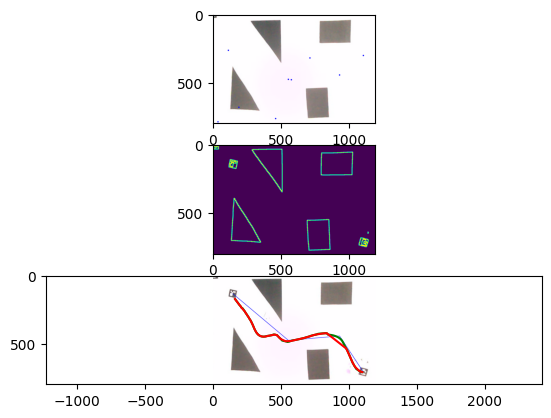

In [22]:
finished = False

detectAndComputePath()

trajectory_x = []
trajectory_y = []

trajectory_kalman_x = []
trajectory_kalman_y = []
i = 0
covered_counter = 0
v,w = 0,0

cc = cv2.VideoWriter_fourcc(*'MP4V')
file = cv2.VideoWriter('output.mp4',cc,10.0, (img.shape[1],img.shape[0]), isColor=True)

while not finished:
    i += 1
    # Getting the position from the camera
    img,origImg = vis.getCorrectedImage()
    file.write(origImg)
    ids,corners = vis.detectArucoMarkers(img)
    foundThymio, thymioPos = vis.getThymioPos(ids,corners) 
 

    if foundThymio:
        ekf.set_mode(extended_kalman_filter.NORMAL)
        
        x_meas, y_meas, theta_meas = thymioPos[0][0], thymioPos[0][1], thymioPos[1] # Position and orientation from the camera
        trajectory_x.append(x_meas)
        trajectory_y.append(y_meas)
        measurement = np.array([x_meas, y_meas, theta_meas, v, w])\
        
        if local_nav.dist(oldThymioPos,thymioPos[0]) > EPSILON_KIDNAP:
            print(" - - - KIDNAPPING DETECTED - RECOMPUTING OPTIMAL PATH - - - ")
            motor_stop()
            time.sleep(3)
            detectAndComputePath()
            continue
        oldThymioPos = thymioPos[0]

    else:
        print("- - - CAMERA COVERED - - -")
        covered_counter += 1
        ekf.set_mode(extended_kalman_filter.KIDNAPPED)

    x, y, theta, v, w = ekf.state
    # print("Camera state:", x_meas,y_meas,theta_meas)
    # print("Kalman state:", x,y,theta)

    (v,w), (wl,wr),finished = local_nav.control((x,y,theta), sensor_data())

    # linear and angular velocity unit conversions
    v = v*19.5/5000
    w = (wl-wr)*8.75/(4.7*500)

    # print('v = ',v,' cm/s\tw = ',w,'rad/s')
    # print('wl = ',wl,'\twr = ',wr)

    control_input = np.array([v,w])
    measurement[3] = v
    measurement[4] = w


    # Perform prediction and update steps
    ekf.predict(control_input, DT)
    ekf.update(measurement)

    x, y, theta, v, w = ekf.state
    trajectory_kalman_x.append(x)
    trajectory_kalman_y.append(y)

    motor_go(int(wl),int(wr))

    time.sleep(DT)
motor_stop()
print("finished at iteration n ", i)
print(f"we have the {covered_counter/i * 100}% covered camera")
plt.imshow(path_img)
plt.plot(np.array(trajectory_kalman_x)/vis.scalingFactor, np.array(trajectory_kalman_y)/vis.scalingFactor, color='green')
plt.plot(np.array(trajectory_x)/vis.scalingFactor, np.array(trajectory_y)/vis.scalingFactor, color='red')
plt.axis('equal')
plt.show()   
file.release()


In [8]:
motor_stop()